In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


## CRNN 구조

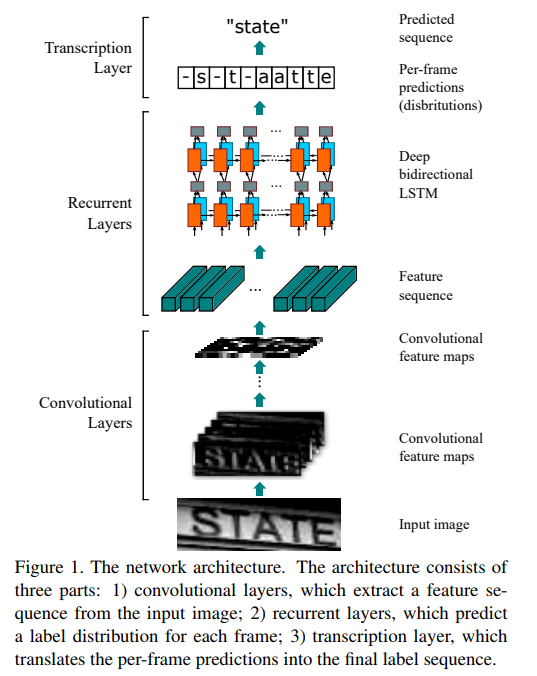

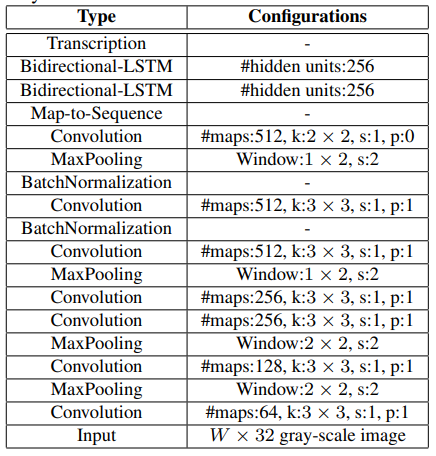

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


대문자와 숫자를 구분하기 위해 36개의 클래스 필요. 
공백까지 구분하면 37개

## 라이브러리 import

In [3]:
import re
import six
import math
import lmdb
import os
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr
from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


**사용할 데이터 : IMDB  
LMDB는 Symas에서 만든 Lightning Memory-Mapped Databas의 약자**

### Input image 4개 확인

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


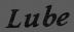

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


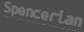

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


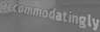

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


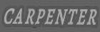

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

MJSynth 데이터셋 구현

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [6]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [69]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [70]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# ModelCheckpoint 설정
ckp = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True)

# EarlyStopping 설정
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# model.fit에 callbacks 추가
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=30,  # EarlyStopping을 사용하면 20을 더 높게 설정해도 됨
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)


Epoch 1/30
565/565 [==============================] - 88s 147ms/step - loss: 25.6119 - val_loss: 24.5146
Epoch 2/30
565/565 [==============================] - 82s 145ms/step - loss: 16.4976 - val_loss: 10.4516
Epoch 3/30
565/565 [==============================] - 83s 147ms/step - loss: 7.6868 - val_loss: 6.4943
Epoch 4/30
565/565 [==============================] - 82s 146ms/step - loss: 5.4200 - val_loss: 5.3805
Epoch 5/30
565/565 [==============================] - 82s 145ms/step - loss: 4.2934 - val_loss: 4.9156
Epoch 6/30
565/565 [==============================] - 82s 144ms/step - loss: 3.5285 - val_loss: 4.3461
Epoch 7/30
565/565 [==============================] - 82s 144ms/step - loss: 2.9399 - val_loss: 4.2433
Epoch 8/30
565/565 [==============================] - 83s 146ms/step - loss: 2.4360 - val_loss: 4.3656
Epoch 9/30
565/565 [==============================] - 82s 145ms/step - loss: 2.0059 - val_loss: 4.2695
Epoch 10/30
565/565 [==============================] - 82s 145ms/step

In [71]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [72]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 50, 16, 64)   0           conv2d_70[0][0]                  
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 50, 16, 128)  73856       max_pooling2d_40[0][0]           
___________________________________________________________________________________________

In [73]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results


# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

## *데이터 예측 - 시퀀스 길이 24 (기본)*

Result: 	 SLINKING9999999999999999


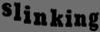

Result: 	 ALEPPO99999999999999999


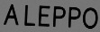

Result: 	 RWENDE999999999999999999


Result: 	 NATHANS99999999999999999


Result: 	 HALLAO99999999999999999


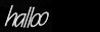

Result: 	 HURLS9999999999999999999


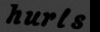

Result: 	 DOWNSIZE9999999999999999


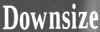

Result: 	 ROBOTIC99999999999999999


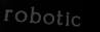

Result: 	 STOPPY99999999999999999


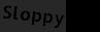

Result: 	 HERMITE99999999999999999


Result: 	 DEARS9999999999999999999


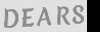

Result: 	 POLYSYLLABIE99999999999


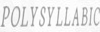

Result: 	 DETEZE999999999999999999


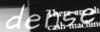

Result: 	 DIAERESES999999999999999


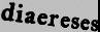

Result: 	 HUMPBACKS999999999999999


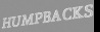

Result: 	 MIOPTED99999999999999999


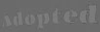

Result: 	 MILIWAUKE999999999999999


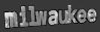

Result: 	 SPEDIFICATION99999999999


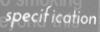

Result: 	 PREACTIONARY999999999999


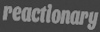

Result: 	 OSCEOL999999999999999999


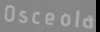

Result: 	 TROROS999999999999999999


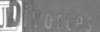

Result: 	 WIDOWED99999999999999999


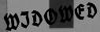

Result: 	 BECHNUT99999999999999999


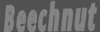

Result: 	 PALYGLETS999999999999999


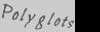

Result: 	 UNGODLIER99999999999999


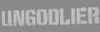

Result: 	 ATAVIST99999999999999999


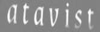

Result: 	 ATERUS999999999999999999


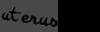

Result: 	 BAREMAED9999999999999999


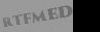

Result: 	 ARDUOUS99999999999999999


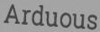

Result: 	 ASLUTP999999999999999999


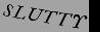

In [74]:
check_inference(model_pred, test_set, index=30)

In [75]:
print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


In [76]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = '/aiffel/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [77]:
img_raw = tf.io.read_file(SAMPLE_IMG_PATH)
img_tensor = tf.image.decode_image(img_raw, channels=3)  # RGB로 디코딩
img_tensor = tf.expand_dims(img_tensor, axis=0)
print("TensorFlow 이미지 쉐입:", img_tensor.shape)  # 이미지 텐서의 쉐이프 출력

TensorFlow 이미지 쉐입: (1, 900, 1200, 3)


In [78]:
def detect_text(img_path):

    # 이미지 불러오기
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (640, 640))
    img = img[tf.newaxis, :, :, :]
    
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    det_result = detector.detect(img.numpy())
    
    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = det_result[0]
    
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

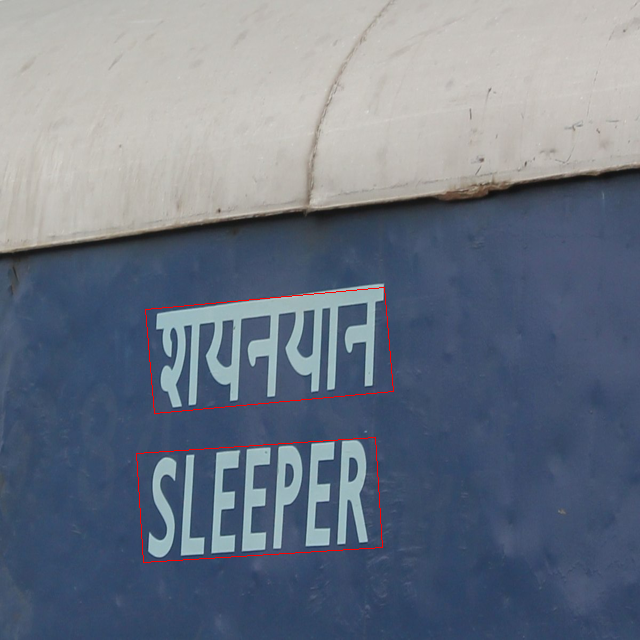

In [79]:
from PIL import Image, ImageDraw

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [80]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 ASTUATUIG999999999999999


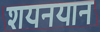

Result: 	 SLEEPER9999999999999999


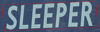

In [81]:
for _img in cropped_img:
    recognize_img(_img)

## 오류 확인
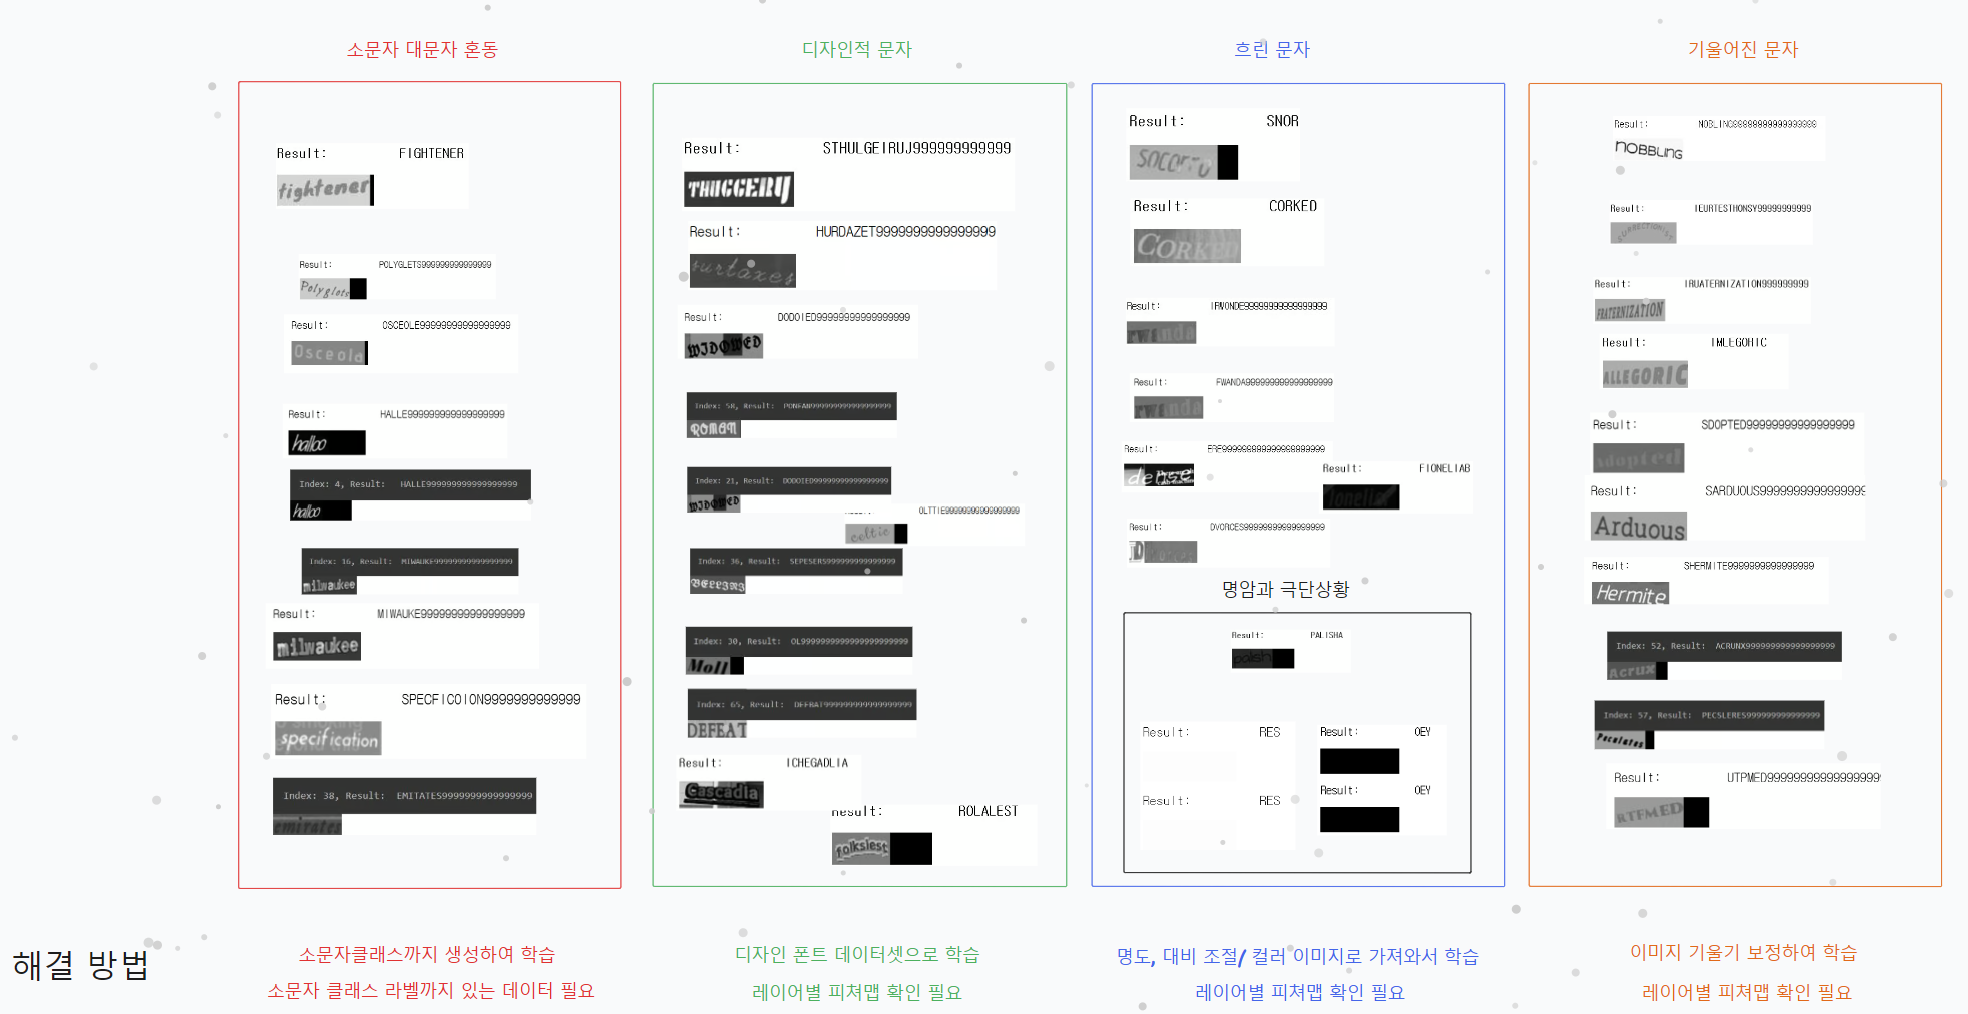

## 추가 실험

- 모델의 시퀀스 길이를 줄여서 결과 확인해보기

1. 시퀀스 길이 12 

In [43]:
class MJDatasetSequence12(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=10,          # 추가실험 시 변경
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [99]:
def build_crnn_model_seq12(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.AveragePooling1D(pool_size=2, strides=2)(sequnce)         # 시퀀스 길이 수정 : 24 -> 12
    sequnce = layers.Dense(64, activation='relu')(sequnce) 
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model


In [ ]:
train_set = MJDatasetSequence12(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence12(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model_seq12()
# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model_seq12.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

checkpoint_path12 = os.getenv('HOME')+'/aiffel/Deep_Dive_CV_RS10/12_OCR/model_checkpoint_seq12.hdf5'

# ModelCheckpoint 설정
ckp = ModelCheckpoint(filepath=checkpoint_path12, monitor='val_loss', save_best_only=True, save_weights_only=True)

# model.fit에 callbacks 추가
model_seq12.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=50,  # EarlyStopping을 사용하면 20을 더 높게 설정해도 됨
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Result: 	 SEUTRUGFCRHIARLS99999999


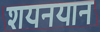

Result: 	 KSLEEPER99999999999999


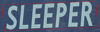

In [104]:
checkpoint_path12 = os.getenv('HOME')+'/aiffel/Deep_Dive_CV_RS10/12_OCR/model_checkpoint_seq12.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model_seq12 = build_crnn_model()
model_seq12.load_weights(checkpoint_path12)       # sequence 길이 12로 훈련한 가중치 사용

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model_seq12.get_layer('input_image').output
y_pred = model_seq12.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

for _img in cropped_img:
    recognize_img(_img)

## *데이터 예측 - 시퀀스 길이 12*

Result: 	 SLINKING9999999999999999


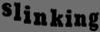

Result: 	 FALEPPO9999999999999999


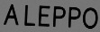

Result: 	 BFRWGIMNDEA999999999999


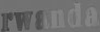

Result: 	 DINATHANS99999999999999


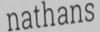

Result: 	 FKHALO999999999999999999


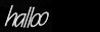

Result: 	 DHURLS999999999999999999


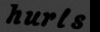

Result: 	 FDOWNSIZE999999999999999


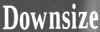

Result: 	 FROBOTIC9999999999999999


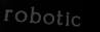

Result: 	 SILOPPY9999999999999999


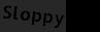

Result: 	 FHERMITE999999999999999


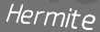

Result: 	 SIDEARS99999999999999999


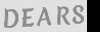

Result: 	 CPOLYSYILLABI9999999999


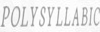

Result: 	 SADALETCREAEAESE9999999


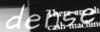

Result: 	 FDIAERESES99999999999999


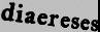

Result: 	 PHEUMPBACKS9999999999999


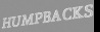

Result: 	 SFMDLOPTEDL999999999999


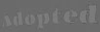

Result: 	 CDMILWAUKEE999999999999


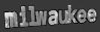

Result: 	 SPECIFICATIO999999999999


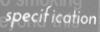

Result: 	 FPREACTIONARY99999999999


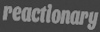

Result: 	 SCDOSCEOLAD9999999999999


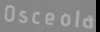

Result: 	 FTLDJRORCES9999999999999


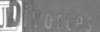

Result: 	 SKIDWDOUMED999999999999


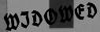

Result: 	 BEECHNRUT9999999999999


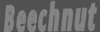

Result: 	 JPOLYGLCTS99999999999999


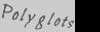

Result: 	 FJUNUGSODULIER9999999999


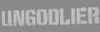

Result: 	 CALTAVIST999999999999999


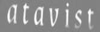

Result: 	 SATERUS99999999999999999


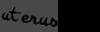

Result: 	 BEAITFEMALED999999999999


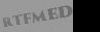

Result: 	 FARDUOUS9999999999999999


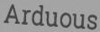

Result: 	 FSTILUTFITTPT9999999999


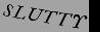

Result: 	 MWLOLL99999999999999999


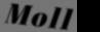

Result: 	 FBENEDICTIO9999999999999


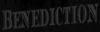

Result: 	 BLLUEPRINT999999999999


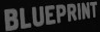

Result: 	 FINICKINAMED99999999999


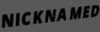

Result: 	 SDISINTEGRATI99999999999


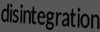

Result: 	 TVOLICELESNE999999999999


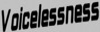

Result: 	 SPBERPESBISRES9999999


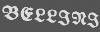

Result: 	 DLICES9999999999999999


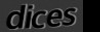

Result: 	 SCEMIRATES99999999999999


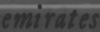

Result: 	 JSPOSPULATION99999999999


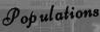

Result: 	 SBREVIVLIFY9999999999999


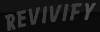

Result: 	 SPUSESIEST9999999999999


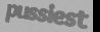

Result: 	 JSCUTAWIZAYS999999999999


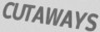

Result: 	 JAPE9999999999999999999


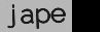

Result: 	 FENUMERAIES999999999999


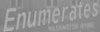

Result: 	 FSTHEODORA99999999999999


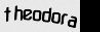

Result: 	 PHAQUSERMEKI999999999999


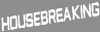

Result: 	 FTAMLPA9999999999999999


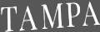

Result: 	 SALTED99999999999999999


Result: 	 STEAQUTILAS9999999999999


Result: 	 FBROULETTE9999999999999


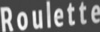

Result: 	 SMAMBUCEA999999999999999


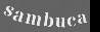

Result: 	 CFACRUMES999999999999999


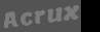

Result: 	 SBMOUOMBITIOVING99999999


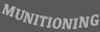

Result: 	 FPENCILED999999999999999


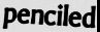

Result: 	 FTHESDONISTS999999999999


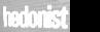

Result: 	 SINITERIARDIN99999999999


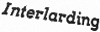

Result: 	 BSPLTESILASIFRES99999999


Result: 	 ROIMGAM9999999999999999


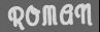

Result: 	 FREMONSIFRUAR99999999999


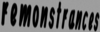

Result: 	 FSTELIESEOP999999999999


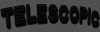

Result: 	 FLOUNGING999999999999999


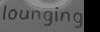

Result: 	 SGEAMDISGUILEAS999999999


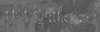

Result: 	 SGERSEDORSIT99999999999


Result: 	 FISK99999999999999999999


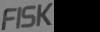

Result: 	 DEFEAT999999999999999999


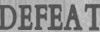

Result: 	 MBOTHERATIO9999999999999


Result: 	 DBRIOCHES999999999999999


Result: 	 SMELLY99999999999999999


Result: 	 SFETHOLOGICA999999999999


Result: 	 SDCRLAUIFS9999999999999


Result: 	 SCDBREIFTRAUABLES9999999


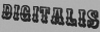

Result: 	 SCREDLITED99999999999999


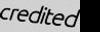

Result: 	 DALIMTIMESS999999999999


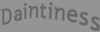

Result: 	 SCPMATSIRETITUTIE9999999


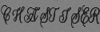

Result: 	 STAYED99999999999999999


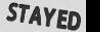

Result: 	 CPSOUIEPSCISCULI99999999


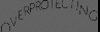

Result: 	 SCARVES99999999999999999


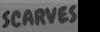

Result: 	 FACQUIRERS99999999999999


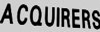

Result: 	 SIONOPADOIGECORG99999999


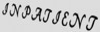

Result: 	 SCUITIVATOE9999999999999


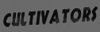

Result: 	 SMOLIFIED999999999999999


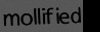

Result: 	 SCONSPIRING9999999999999


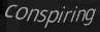

Result: 	 SCOMPILING99999999999999


Result: 	 SHADOWY9999999999999999


Result: 	 JSCOINSERVING99999999999


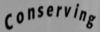

Result: 	 FSPACES9999999999999999


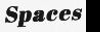

Result: 	 DPISATIFATI9999999999999


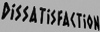

Result: 	 DOER999999999999999999


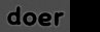

Result: 	 SPASHAS99999999999999999


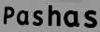

Result: 	 FREIMBIBURSEME9999999999


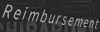

Result: 	 SITRICIURES9999999999999


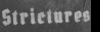

Result: 	 PSMUDDIER99999999999999


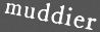

Result: 	 SBLTITCHELY9999999999999


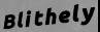

Result: 	 SEAMIEN9999999999999999


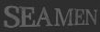

Result: 	 SCATHILETICAL99999999999


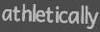

Result: 	 TVERITY9999999999999999


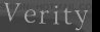

Result: 	 CPROPAGAPATIOS9999999999


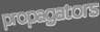

Result: 	 PEERESS99999999999999


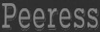

Result: 	 FRAPTLY99999999999999999


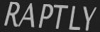

Result: 	 FSIREN999999999999999999


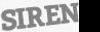

Result: 	 SPLASTHETILC999999999999


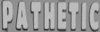

Result: 	 JFTOPEES999999999999999


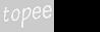

Result: 	 FCBREASTS99999999999999


Result: 	 FRECOUAQUERS999999999999


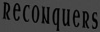

Result: 	 TPROSPECTUSE999999999999


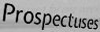

Result: 	 JDECOLETAGES999999999999


Result: 	 SBEHOOWVE99999999999999


Result: 	 CLWUREZMULITS99999999999


Result: 	 SATCMANM9999999999999999


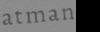

Result: 	 SFPRIVATIER9999999999999


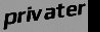

Result: 	 FSPUTTERED9999999999999


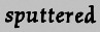

Result: 	 BURROUGHS9999999999999


Result: 	 JZSE9999999999999999999


Result: 	 PHOLLYHOCK9999999999999


Result: 	 5DOLS9999999999999999999


Result: 	 SCOIOPHONS99999999999999


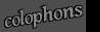

Result: 	 BSTARAETITIETPNGA9999999


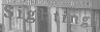

Result: 	 FTIFTAP999999999999999


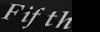

Result: 	 COURCROPEPS9999999999999


Result: 	 FLINESMERI99999999999999


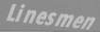

Result: 	 SFESUMCILUTEOTES99999999


Result: 	 SDOVECEIRU999999999999


Result: 	 SFPURFRECHASIBL999999999


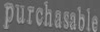

Result: 	 SFJBORICULURINT999999999


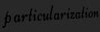

Result: 	 SWFTILLIGE9999999999999


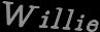

Result: 	 FIBOUVLOGEAIEA9999999999


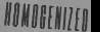

Result: 	 SPRINTINGS9999999999999


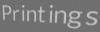

Result: 	 SFCOMPILATION99999999999


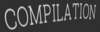

Result: 	 FELAMILESSL999999999999


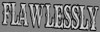

Result: 	 SKURDISH9999999999999999


Result: 	 SCGLSTENED99999999999999


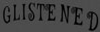

Result: 	 SOUTHS99999999999999999


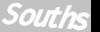

Result: 	 BEEFINESS9999999999999


Result: 	 BRAMABLLY9999999999999


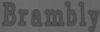

Result: 	 SCODASITILING99999999999


Result: 	 SMACEGILULIN999999999999


Result: 	 SCREWBAL999999999999999


Result: 	 FLUXURIANITILY9999999999


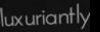

Result: 	 DEFAQULITER9999999999999


Result: 	 GOBLINDS999999999999999


Result: 	 STLIDEAELIRPRINS99999999


Result: 	 SIRSALIGATIAMTI999999999


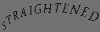

Result: 	 SBEDFELLOWY999999999999


Result: 	 SWORKHOUT999999999999999


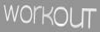

Result: 	 JAVWDAND9999999999999999


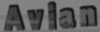

Result: 	 FEXAMPLED99999999999999


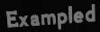

Result: 	 SCORACHIDOUIN9999999999


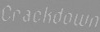

Result: 	 DEFERRALS99999999999999


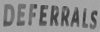

Result: 	 SFREOURDERIMNG999999999


Result: 	 FLEONINME999999999999999


Result: 	 SDERALILIFUR999999999999


Result: 	 SPHIRESICUMATAI999999999


Result: 	 PFURBELOW999999999999999


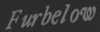

Result: 	 FHRESEWUNI99999999999999


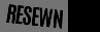

Result: 	 SCBEBEXAPOUMDER999999999


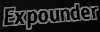

Result: 	 SDREIFLOALED99999999999


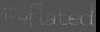

Result: 	 FOFFLEID99999999999999


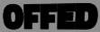

Result: 	 BEHIE99999999999999999


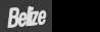

Result: 	 AIRBAGS999999999999999


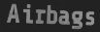

Result: 	 FSAYATOLAIS999999999999


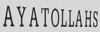

Result: 	 SPEMBROKE999999999999999


Result: 	 PHEMORHAGI99999999999999


Result: 	 SBRICIBUICTIAS9999999999


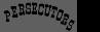

Result: 	 FINAGLING999999999999999


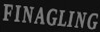

Result: 	 DBOOHOOING999999999999


Result: 	 STFIPLIOPS999999999999


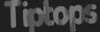

Result: 	 STARLET9999999999999999


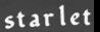

Result: 	 SPIRPPLAFHERT9999999999


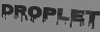

Result: 	 JTUMCLEAR999999999999999


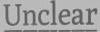

Result: 	 CDAINVYEAND999999999999


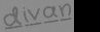

Result: 	 STVYLIESAIM9999999999999


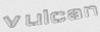

Result: 	 BFREECITED9999999999999


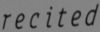

Result: 	 DASTDLIRESD9999999999999


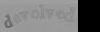

Result: 	 FCGRINDSTONE999999999999


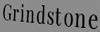

Result: 	 GITE9999999999999999999


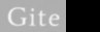

Result: 	 FOOTHILIE99999999999999


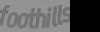

Result: 	 PIFEAGNANTS9999999999


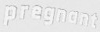

Result: 	 FTAGGERS999999999999999


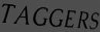

Result: 	 SNUAPROARIOUSL9999999999


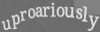

Result: 	 GCALVLES999999999999999


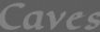

Result: 	 FISAOMERS999999999999999


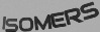

Result: 	 STEDILIGONTORI9999999999


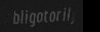

Result: 	 BEATTNAUIK999999999999


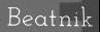

Result: 	 FAMOUS999999999999999999


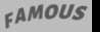

Result: 	 SIDESERITING999999999999


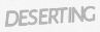

Result: 	 SLEEPY9999999999999999


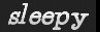

Result: 	 DPAIREADIRALES999999999


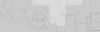

Result: 	 ESYPITED999999999999999


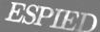

Result: 	 SMUTTIEST9999999999999


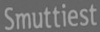

Result: 	 JDESITINLY99999999999999


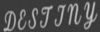

Result: 	 STRANSFORIMIE99999999999


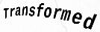

Result: 	 SCONLGQUEROI999999999999


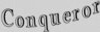

Result: 	 SCHOLIRO9999999999999999


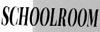

Result: 	 SCARILEBRATCOS9999999999


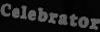

Result: 	 PSGORINWISH9999999999999


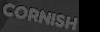

Result: 	 SWEIZAMOMN999999999999


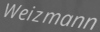

Result: 	 FRESCES99999999999999999


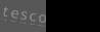

Result: 	 FSTYLES99999999999999999


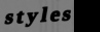

Result: 	 SHITCHER999999999999999


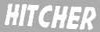

Result: 	 SGCALBAL999999999999999


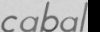

Result: 	 SBANLIBEACTERAES99999999


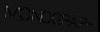

Result: 	 SFROGQUEBOPRT9999999999


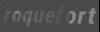

Result: 	 FSTINAOERINAS99999999999


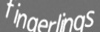

Result: 	 FEMINIZING99999999999999


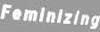

Result: 	 SKWTHAMMIY9999999999999


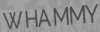

Result: 	 CFUNTERIVEDY999999999999


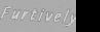

Result: 	 FCNLUIFTCURER9999999999


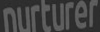

Result: 	 DSEWAINESCENT99999999999


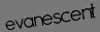

Result: 	 PSTLARSESS9999999999999


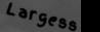

Result: 	 FAMANESIAD99999999999999


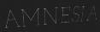

Result: 	 FRECIAVESTED99999999999


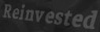

Result: 	 FINONELIECTRI99999999999


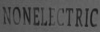

Result: 	 SCASTLING999999999999999


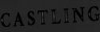

Result: 	 JECRECAY9999999999999999


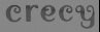

Result: 	 SQUADRUPLE99999999999999


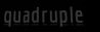

Result: 	 FGROSSING99999999999999


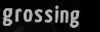

Result: 	 SIS99999999999999999999


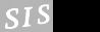

Result: 	 FLIGNITEDL9999999999999


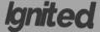

Result: 	 SGREULILUS9999999999999


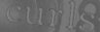

Result: 	 SCELIF999999999999999999


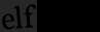

Result: 	 SCHIORIAIOLIDILIH9999999


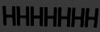

Result: 	 PIMOMENTOUS9999999999999


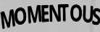

Result: 	 JTHICKINESSE99999999999


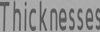

Result: 	 STABBING999999999999999


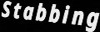

Result: 	 SDIMNERADICAUB9999999999


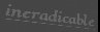

Result: 	 BMAYITHAS999999999999999


Result: 	 JGCARIBMAP9999999999999


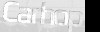

Result: 	 PUFTY999999999999999999


Result: 	 ATIP9999999999999999999


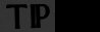

Result: 	 WOO9999999999999999999


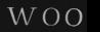

Result: 	 STATIOM9999999999999999


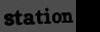

Result: 	 FLAKSHAMIL999999999999


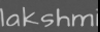

Result: 	 CUNMATIRIBRUTE9999999999


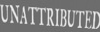

Result: 	 TIMDIVIDUALIT99999999999


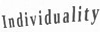

Result: 	 SBMIARCEL9999999999999


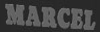

Result: 	 SVERBOSE999999999999999


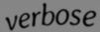

Result: 	 SBATRITLEDRES99999999999


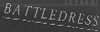

Result: 	 SZEALATCRY99999999999999


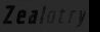

Result: 	 SJIOLUNIESPRED9999999999


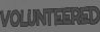

Result: 	 FLLANTERA99999999999999


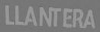

Result: 	 SPAILUITES99999999999999


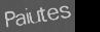

Result: 	 DSE99999999999999999999


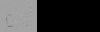

Result: 	 SWOHAILEBONE999999999999


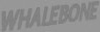

Result: 	 FLACTATE9999999999999999


Result: 	 JDISPATICH99999999999999


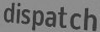

Result: 	 CSMUSSOLIN9999999999999


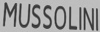

Result: 	 SHUEILAS999999999999999


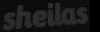

Result: 	 SOUTHWVESTE9999999999999


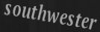

Result: 	 SILITIEST999999999999999


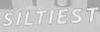

Result: 	 SGRANDMAS999999999999999


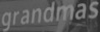

Result: 	 STUFO9999999999999999999


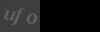

Result: 	 CHARTERER999999999999999


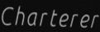

Result: 	 SKININED99999999999999


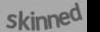

Result: 	 FREDIMUND9999999999999


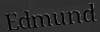

Result: 	 DARZEDLY999999999999999


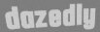

Result: 	 FRINSLING99999999999999


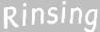

Result: 	 DITDADS999999999999999


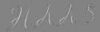

Result: 	 SCULTIVATO99999999999999


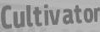

Result: 	 SFINGERINGS9999999999999


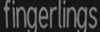

Result: 	 FAZLES999999999999999999


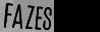

Result: 	 SCHARGED999999999999999


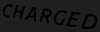

Result: 	 SMOONSGHINE999999999999


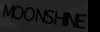

Result: 	 SPHLGHILGHTER99999999999


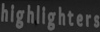

Result: 	 SPRIMPACY99999999999999


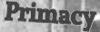

Result: 	 STPIREIMAITUMS9999999999


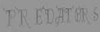

Result: 	 SGPIONMPECE9999999999999


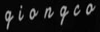

Result: 	 BFREVERTING9999999999999


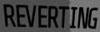

Result: 	 SDOMSIULARYS999999999999


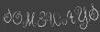

Result: 	 SBANIYISRG9999999999999


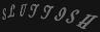

Result: 	 FVYAPRPEAOAMER9999999999


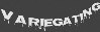

Result: 	 SEALIESMES99999999999999


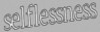

Result: 	 DOISIEAROSL9999999999999


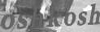

Result: 	 SCESCALOPED99999999999


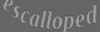

Result: 	 STIENACERPIOLGF999999999


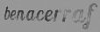

Result: 	 FLCAKIEST999999999999999


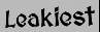

Result: 	 FCOUTICILARBACL999999999


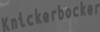

Result: 	 FIMDELIVERS9999999999999


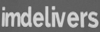

Result: 	 JGCOGNIZAMES999999999999


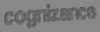

Result: 	 SCISPOSERS99999999999999


Result: 	 PELIF999999999999999999


Result: 	 PSCEICOWMECAWVE999999999


Result: 	 STZIPPERS9999999999999


Result: 	 SCEMIJOIMNS9999999999999


Result: 	 SBULITONTIM9999999999999


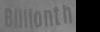

Result: 	 BARCELONEA9999999999999


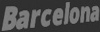

Result: 	 FREVLISE999999999999999


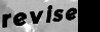

Result: 	 FKREODLEPOSTI99999999999


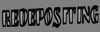

Result: 	 FDEGRADATIO9999999999999


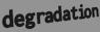

Result: 	 FASSIGNERS9999999999999


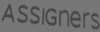

Result: 	 SPRAYER99999999999999999


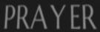

Result: 	 PLEAPHENARAE99999999999


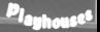

Result: 	 JDISBARRED9999999999999


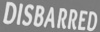

Result: 	 FLOQUNS99999999999999999


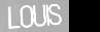

Result: 	 SEMUISIES999999999999999


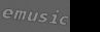

Result: 	 FDINICOLAS99999999999999


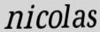

Result: 	 SPOULITRERIER99999999999


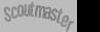

Result: 	 FHIYPOTHERICA99999999999


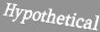

Result: 	 SNORKELS999999999999999


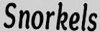

Result: 	 PLINTUMERIG9999999999999


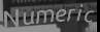

In [105]:
check_inference(model_pred, test_set, index=300)

결과 : 22로 길이를 설정했을 때보다 끝 부분 예측은 잘 했지만 앞 부분을 예측하지 못함  
    SLEEPER의 맨 앞에 K가 붙는 이유?  
    TEST 데이터에서도 앞 부분에 알파벳이 추가되는 경우가 많아짐  
    시퀀스가 작아질수록 더 예측을 잘 하는 것인지 한번 더 시퀀스를 줄여서 실험

2. 시퀀스 길이 6

In [79]:
class MJDatasetSequence6(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=4,          # 추가실험 시 변경
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [80]:
def build_crnn_model_seq6(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.AveragePooling1D(pool_size=2, strides=2)(sequnce)         # 시퀀스 길이 수정 : 24 -> 12
    sequnce = layers.AveragePooling1D(pool_size=2, strides=2)(sequnce)         # 시퀀스 길이 수정 : 12 -> 6
    sequnce = layers.Dense(64, activation='relu')(sequnce) 
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model


In [ ]:
train_set = MJDatasetSequence6(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence6(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model_seq6 = build_crnn_model_seq6()
# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model_seq6.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

checkpoint_path6 = os.getenv('HOME')+'/aiffel/Deep_Dive_CV_RS10/12_OCR/model_checkpoint_seq6.hdf5'

# ModelCheckpoint 설정
ckp = ModelCheckpoint(filepath=checkpoint_path6, monitor='val_loss', save_best_only=True, save_weights_only=True)

# model.fit에 callbacks 추가
model_seq6.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=50,  # EarlyStopping을 사용하면 20을 더 높게 설정해도 됨
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Result: 	 SGSGNIN99999999999999999


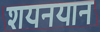

Result: 	 SLESELE99999999999999999


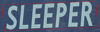

In [90]:
checkpoint_path6 = os.getenv('HOME')+'/aiffel/Deep_Dive_CV_RS10/12_OCR/model_checkpoint_seq6.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model_seq22 = build_crnn_model()
model_seq22.load_weights(checkpoint_path6)     #Sequence가 6인 가중치로 분류할 수 있을까?

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model_seq22.get_layer('input_image').output
y_pred = model_seq22.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

for _img in cropped_img:
    recognize_img(_img)

## *데이터 예측 - 시퀀스 길이 6*

Result: 	 SLSKIN999999999999999999


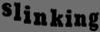

Result: 	 SASLEIPE9999999999999999


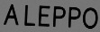

Result: 	 SFKSWSKWHNHK999999999999


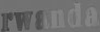

Result: 	 SFINATGBANA9999999999999


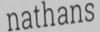

Result: 	 SKNKNAKNKN99999999999999


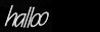

Result: 	 SHMSWSMNUG99999999999999


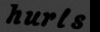

Result: 	 SDWNWHWN9999999999999999


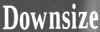

Result: 	 SFRFOBO99999999999999999


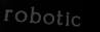

Result: 	 SMN999999999999999999999


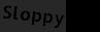

Result: 	 SHFELEBSEMIR999999999999


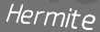

Result: 	 SDSEBGARNGE9999999999999


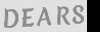

Result: 	 PBPNMPNIYN99999999999999


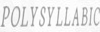

Result: 	 SESESEHNE999999999999999


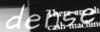

Result: 	 SDIMADARAE99999999999999


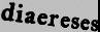

Result: 	 SBSGBKBMBHK9999999999999


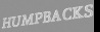

Result: 	 SBMDBDSMSANVN99999999999


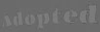

Result: 	 SMSMSIMHNIK9999999999999


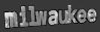

Result: 	 SPSPRS999999999999999999


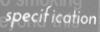

Result: 	 SPRESERNRENEN99999999999


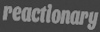

Result: 	 SDSCSCIS9999999999999999


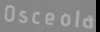

Result: 	 SFLODSISWNG9999999999999


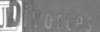

Result: 	 SBSWNSHNHNE9999999999999


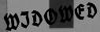

Result: 	 SBSBSGBE9999999999999999


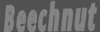

Result: 	 SPBFBPBIAN99999999999999


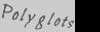

Result: 	 SCUBNIMSGBNHNIN999999999


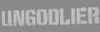

Result: 	 SGSAFTCACAVANCAN99999999


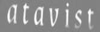

Result: 	 SDSTSCKVGANX999999999999


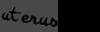

Result: 	 SBCBEBENE999999999999999


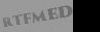

Result: 	 SABABADIVUNOQN9999999999


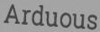

Result: 	 SKEVE9999999999999999999


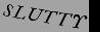

Result: 	 SMSBSBLOILN9999999999999


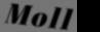

Result: 	 SBE999999999999999999999


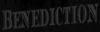

Result: 	 BLBUBEBE9999999999999999


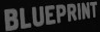

Result: 	 SNMISCSKNK99999999999999


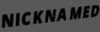

Result: 	 DSMIMIMI9999999999999999


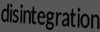

Result: 	 SVWBTSKEK999999999999999


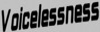

Result: 	 SBGBG9999999999999999999


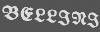

Result: 	 SGSDLDGCGAGI999999999999


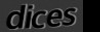

Result: 	 SGCBSCBMENIE999999999999


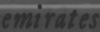

Result: 	 SGPSGSNG9999999999999999


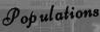

Result: 	 SMRTSESNVN99999999999999


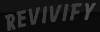

Result: 	 SFPSBSBIBIS9999999999999


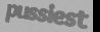

Result: 	 SCUBTCBMUAN9999999999999


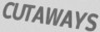

Result: 	 SJSJPJEAN999999999999999


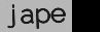

Result: 	 SENEGMBUNHNRK99999999999


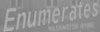

Result: 	 STSEBEHRN999999999999999


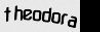

Result: 	 SHNGJNSGMNURS99999999999


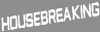

Result: 	 STAMIMPIP999999999999999


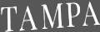

Result: 	 SG9999999999999999999999


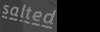

Result: 	 STEGAINA9999999999999999


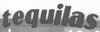

Result: 	 SBRCNCWUOLIT999999999999


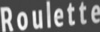

Result: 	 SGAMBMIN9999999999999999


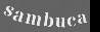

Result: 	 SASCSEUNUIN9999999999999


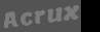

Result: 	 BMSBSBUIN999999999999999


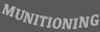

Result: 	 SPSNCNIN9999999999999999


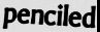

Result: 	 SLBENE999999999999999999


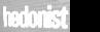

Result: 	 SIMIFELINE99999999999999


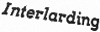

Result: 	 SPASCBANE999999999999999


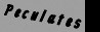

Result: 	 PSPRDNMNRGNG999999999999


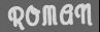

Result: 	 SFESMBMSEHME999999999999


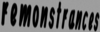

Result: 	 STBNBGE99999999999999999


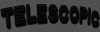

Result: 	 STLABGBGBNIG999999999999


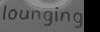

Result: 	 SDSNTNSNMNIN999999999999


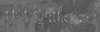

Result: 	 SGSBSGENHIE9999999999999


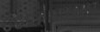

Result: 	 SFSKSKSK9999999999999999


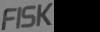

Result: 	 SDBEBFBERE99999999999999


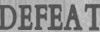

Result: 	 SBNTBHNXTN99999999999999


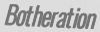

Result: 	 BRIBGHN99999999999999999


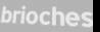

Result: 	 SMSELE999999999999999999


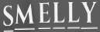

Result: 	 SGHEBEHG9999999999999999


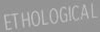

Result: 	 SMSMNHNHN999999999999999


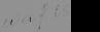

Result: 	 BDBHN9999999999999999999


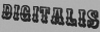

Result: 	 SCREDCRER999999999999999


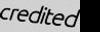

Result: 	 DBDMIN999999999999999999


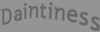

Result: 	 SGCGBARGCN99999999999999


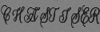

Result: 	 STSASVEYT999999999999999


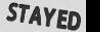

Result: 	 SESENUN99999999999999999


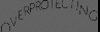

Result: 	 SCSKGVNGE999999999999999


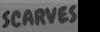

Result: 	 SASGCAGAQU99999999999999


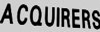

Result: 	 SIBIBNINTN99999999999999


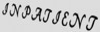

Result: 	 SCUCGVATON99999999999999


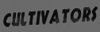

Result: 	 SMSMNMILI999999999999999


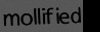

Result: 	 SCNCNONRN999999999999999


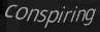

Result: 	 SCDSDMPOUIN9999999999999


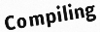

Result: 	 SAHDS9999999999999999999


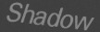

Result: 	 SCGNGNONGRN9999999999999


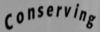

Result: 	 SPSACS999999999999999999


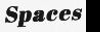

Result: 	 PBMBAS999999999999999999


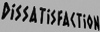

Result: 	 SDODNDMDRENO999999999999


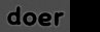

Result: 	 PABSHAH99999999999999999


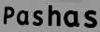

Result: 	 SFRFSBMBMN99999999999999


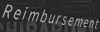

Result: 	 SRSMIRN99999999999999999


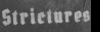

Result: 	 SMSMSWMDSDID999999999999


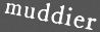

Result: 	 SBSBSTBNEIE9999999999999


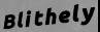

Result: 	 SESBMAMHM999999999999999


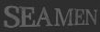

Result: 	 SBASTCBTBEINCE9999999999


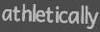

Result: 	 SWVSCECRESCERN9999999999


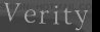

Result: 	 BFEGBFBFPNIN999999999999


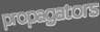

Result: 	 SPSESFGEGE99999999999999


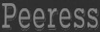

Result: 	 SFRBATPTIT99999999999999


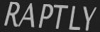

In [91]:
check_inference(model_pred, test_set, index=100)

결과 : 오히려 시퀀스 길이가 작아지면서 단어를 전혀 예측하지 못함  
시퀀스 길이가 짧기 때문인지 단어의 길이조차 예측하지 못하는 현상을 보임  
오히려 길이를 늘려서 실험을 진행하는 과정이 필요해보임

3. 시퀀스 길이 49

In [106]:
class MJDatasetSequence49(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=47,          # 추가실험 시 변경
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [109]:
def build_crnn_model_seq49(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(49, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce) 
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model


In [121]:
train_set = MJDatasetSequence49(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence49(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model_seq49 = build_crnn_model_seq49()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model_seq49.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

checkpoint_path49 = os.getenv('HOME')+'/aiffel/Deep_Dive_CV_RS10/12_OCR/model_checkpoint_seq49.hdf5'

# ModelCheckpoint 설정
ckp = ModelCheckpoint(filepath=checkpoint_path49, monitor='val_loss', save_best_only=True, save_weights_only=True)

# model.fit에 callbacks 추가
model_seq49.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=50,  # EarlyStopping을 사용하면 20을 더 높게 설정해도 됨
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/50
565/565 [==============================] - 127s 212ms/step - loss: 25.8196 - val_loss: 22.8252
Epoch 2/50
565/565 [==============================] - 118s 209ms/step - loss: 11.8232 - val_loss: 6.9280
Epoch 3/50
565/565 [==============================] - 117s 208ms/step - loss: 5.3367 - val_loss: 4.8610
Epoch 4/50
565/565 [==============================] - 117s 207ms/step - loss: 3.8771 - val_loss: 4.0637
Epoch 5/50
565/565 [==============================] - 117s 207ms/step - loss: 3.1069 - val_loss: 3.6351
Epoch 6/50
565/565 [==============================] - 117s 207ms/step - loss: 2.5632 - val_loss: 3.3882
Epoch 7/50
565/565 [==============================] - 117s 207ms/step - loss: 2.1421 - val_loss: 3.2317
Epoch 8/50
565/565 [==============================] - 117s 207ms/step - loss: 1.7914 - val_loss: 3.4466
Epoch 9/50
565/565 [==============================] - 116s 206ms/step - loss: 1.4898 - val_loss: 3.2224
Epoch 10/50
565/565 [==============================] - 117s 2

Result: 	 AR9999999999999999999999


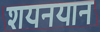

Result: 	 SIEPER99999999999999999


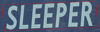

In [118]:
checkpoint_path49 = os.getenv('HOME')+'/aiffel/Deep_Dive_CV_RS10/12_OCR/model_checkpoint_seq6.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model_seq22 = build_crnn_model()
model_seq22.load_weights(checkpoint_path49)     #Sequence가 6인 가중치로 분류할 수 있을까?

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model_seq22.get_layer('input_image').output
y_pred = model_seq22.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

for _img in cropped_img:
    recognize_img(_img)

## *데이터 예측 - 시퀀스 길이 49*

Result: 	 SLINKING9999999999999999


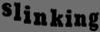

Result: 	 ALEPPO99999999999999999


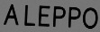

Result: 	 RINDE9999999999999999999


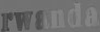

Result: 	 NATHANS99999999999999999


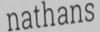

Result: 	 WA9999999999999999999999


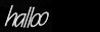

Result: 	 HURIS9999999999999999999


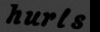

Result: 	 DOWISIZE9999999999999999


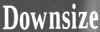

Result: 	 ROBOIC999999999999999999


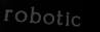

Result: 	 SOPY99999999999999999999


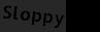

Result: 	 HERMIE999999999999999999


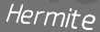

Result: 	 DEARS9999999999999999999


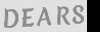

Result: 	 POISLSI99999999999999999


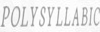

Result: 	 DETE99999999999999999999


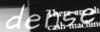

Result: 	 DIAERCIES999999999999999


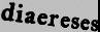

Result: 	 RUPACKS99999999999999999


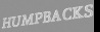

Result: 	 MIOPTED99999999999999999


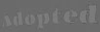

Result: 	 MILVAIES9999999999999999


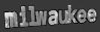

Result: 	 PRDICDIN9999999999999999


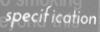

Result: 	 REICIONRY999999999999999


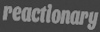

Result: 	 DSCEDLA99999999999999999


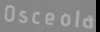

Result: 	 BWRES9999999999999999999


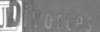

Result: 	 BDOIED999999999999999999


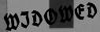

Result: 	 BECINUT99999999999999999


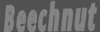

Result: 	 RINGUS999999999999999999


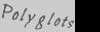

Result: 	 INGODLER9999999999999999


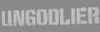

Result: 	 ATAVIST99999999999999999


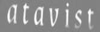

Result: 	 TOUS99999999999999999999


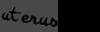

Result: 	 UIMED9999999999999999999


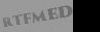

Result: 	 ARDIOUS99999999999999999


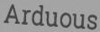

Result: 	 SZUTT999999999999999999


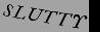

Result: 	 WOL999999999999999999999


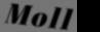

Result: 	 BENDCION9999999999999999


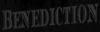

Result: 	 BLUEPRIY9999999999999999


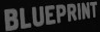

Result: 	 NCKMANED9999999999999999


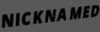

Result: 	 ISNEGAION999999999999999


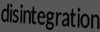

Result: 	 OIAESNESS99999999999999


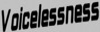

Result: 	 SCOGOS999999999999999999


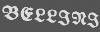

Result: 	 DICES9999999999999999999


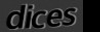

Result: 	 MIAS99999999999999999999


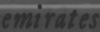

Result: 	 DEDIOS999999999999999999


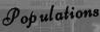

Result: 	 REWVFY999999999999999999


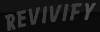

Result: 	 PSIEST999999999999999999


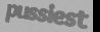

Result: 	 CUAWAYS99999999999999999


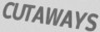

Result: 	 JAPE99999999999999999999


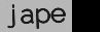

Result: 	 ENUNEDES9999999999999999


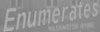

Result: 	 THERITA99999999999999999


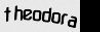

Result: 	 MSEKNG999999999999999999


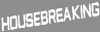

Result: 	 TAMPA9999999999999999999


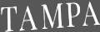

Result: 	 DIED99999999999999999999


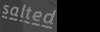

Result: 	 CEQUILAS9999999999999999


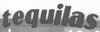

Result: 	 ROLETTE9999999999999999


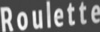

Result: 	 AMBUED999999999999999999


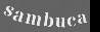

Result: 	 ACRUR9999999999999999999


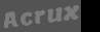

Result: 	 HIANMIOUND99999999999999


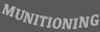

Result: 	 PENCILED9999999999999999


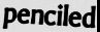

Result: 	 BIS999999999999999999999


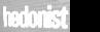

Result: 	 NERING999999999999999999


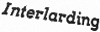

Result: 	 TCINES999999999999999999


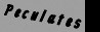

Result: 	 RIED99999999999999999999


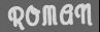

Result: 	 CONOSTOKS999999999999999


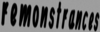

Result: 	 PAIVEOK99999999999999999


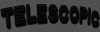

Result: 	 LOUINGING999999999999999


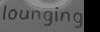

Result: 	 NIRAT9999999999999999999


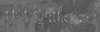

Result: 	 CES999999999999999999999


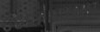

Result: 	 FSK999999999999999999999


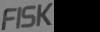

Result: 	 DEREAT999999999999999999


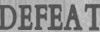

Result: 	 BIEATIN99999999999999999


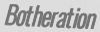

Result: 	 PRIOCHES9999999999999999


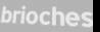

Result: 	 SMELLY99999999999999999


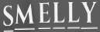

Result: 	 EHOLOSCL9999999999999999


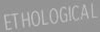

Result: 	 RAH999999999999999999999


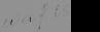

Result: 	 DARALS999999999999999999


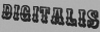

Result: 	 EDIED9999999999999999999


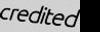

Result: 	 PANTNESS999999999999999


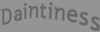

Result: 	 CISIN9999999999999999999


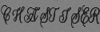

Result: 	 STAYED999999999999999999


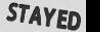

Result: 	 UNTATING9999999999999999


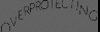

Result: 	 CARES9999999999999999999


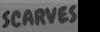

Result: 	 ACQURERS9999999999999999


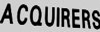

Result: 	 NATEND999999999999999999


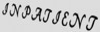

Result: 	 CUNAROS99999999999999999


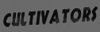

Result: 	 ROLIFED99999999999999999


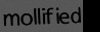

Result: 	 COSPIN999999999999999999


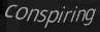

Result: 	 COMPITING999999999999999


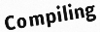

Result: 	 SHADOW999999999999999999


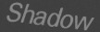

Result: 	 COISONING999999999999999


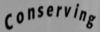

Result: 	 SPACES999999999999999999


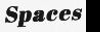

Result: 	 ISAIBATIN999999999999999


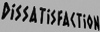

Result: 	 DOER99999999999999999999


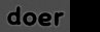

Result: 	 PASHAS999999999999999999


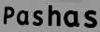

Result: 	 RENOUEART999999999999999


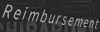

Result: 	 SRICIRES9999999999999999


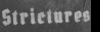

Result: 	 NUDIER999999999999999999


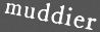

Result: 	 BLITHELY9999999999999999


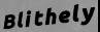

Result: 	 SEAMEN999999999999999999


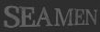

Result: 	 CHETICALY999999999999999


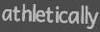

Result: 	 VERITY999999999999999999


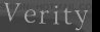

Result: 	 ROMAINS99999999999999999


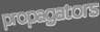

Result: 	 PEERESS999999999999999


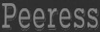

Result: 	 RAPTLY999999999999999999


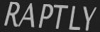

In [119]:
check_inference(model_pred, test_set, index=100)

결과 : 앞 부분의 랜덤한 알파벳이 예측되는 현상이 많이 개선됨  
하지만 시퀀스의 길이가 길면 장기 의존성 문제가 나타나 긴 단어를 잘 예측하지 못함  

## 회고  

OCR의 코드 구조를 이해하는 데에 어려움을 겪었다.  
처음에 알파벳을 잘 유추하지 못하는 이유를 시퀀스가 너무 잘게 쪼개져서라고 판단하여 시퀀스의 길이를 비교해보는 실험을 진행해봤는데  
오히려 시퀀스 길이를 더 늘렸을 때 문제가 해결되는 현상이 일어났다. 하지만 해결된 이유까지 가늠해보지 못해서 이 부분에 대한 이해도 필요하다.  
추가로 장기 의존성 문제를 해결하고 싶었지만 이 부분까지 해결하지 못했다.. 여러모로 아쉬운 프로젝트였다.